In [2]:
##############################
# Author: Jacob van de Lindt
# Date:   May 22, 2023
# MIT PSFC
##############################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from matplotlib import ticker, cm 
import os, sys
import netCDF4

In [3]:
# Setting up the paths to the local directory
# abspath = os.path.abspath('')
# dname = os.path.dirname(abspath)
# print(abspath)
# os.chdir(dname)
wkdir = os.getcwdb()


In [4]:
# Loading up the netcdf4 datasets
remoteDirectory = open(f'../remoteDirectory.txt', 'r').readlines()[0].strip()
shotNum = remoteDirectory.split('/')[-1].split('_')[1]
cql_nc = netCDF4.Dataset(f'../shots/{shotNum}/cql3d.nc','r')
cqlrf_nc = netCDF4.Dataset(f'../shots/{shotNum}/cql3d_krf001.nc','r')



In [5]:
# Get particle properties
#cql_nc.variables.keys()
# get the radial points where f was solved
rya = cql_nc.variables["rya"][:]#radial points at which f was solved: "Normalized radial mesh at bin centers"


#pitch angles mesh at which f is defined in radians.
#Note that np.ma.getdata pulls data through mask which
# rejects bad data (NAN, etc)
pitchAngleMesh = np.ma.getdata(cql_nc.variables["y"][:])   # y is pitch angle, x is velocity (momentum per mass)

#normalized speed mesh of f
normalizedVel = cql_nc.variables["x"][:]
#print(normalizedVel.shape)

#energy  = restmkev*(gamma-1)
#energies corresponding to velocities jx
enerkev = cql_nc.variables["enerkev"][:] 

#flux surface average energy per particle in keV 
energy = cql_nc.variables["energy"][:] #(tdim, r0dim, species_dim)
# so for example, energy[0, 0] gets an array at time zero and r[0] that is filled with 
# one energy for a species i. Note that we can have both maxwellian
# and general for each species
print(enerkev.shape)
print(energy.shape)
print(energy[0, 0])
print(energy[100, 0])

print(pitchAngleMesh.shape)
print(normalizedVel.shape)
print(enerkev[-1])

(400,)
(101, 35, 5)
[10.81435228 10.26493844 10.874933   10.874933   10.27389462]
[27.9578716   9.95399211 10.874933   10.874933   10.27389462]
(35, 200)
(400,)
18352178.813898113


(2, 35, 400, 200)
(400,)


<ipython-input-9-88a35db0e557>:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(VPARA, VPERP, np.log(f_at_rho.T+1))#f_at_rho.T)#np.log(f_at_rho.T+1))


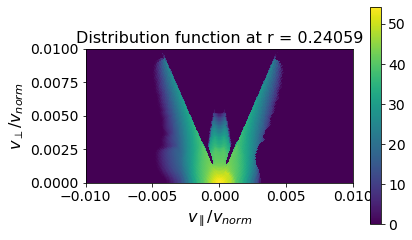

8


In [9]:
# distrobution function 
#distribution function (lrz, jx, iy)
#vnorm^3*s^3/cm^6
f = cql_nc.variables["f"][:]
print(f.shape)
print(enerkev.shape)

## Plot the distrobution function at a particular rho
rho = 0.25
i_rho = np.argmin(np.abs(rho - rya))

f_at_rho = f[0, i_rho, :, :]#f[0, i_rho, :, :]
max_v_over_vnorm_to_plot = 0.01 #0.4 #5e-3

pitchAngles = pitchAngleMesh[i_rho,:]
x = cql_nc.variables["x"][:]

V, Theta = np.meshgrid(x, pitchAngles)
VPARA = V*np.cos(Theta); VPERP = V*np.sin(Theta)

plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('axes', labelsize = 16)
plt.rc('axes', titlesize = 16)
plt.rc('figure', titlesize = 18)
plt.rc('legend', fontsize = 14)
fig,ax = plt.subplots()
pc = ax.pcolormesh(VPARA, VPERP, np.log(f_at_rho.T+1))#f_at_rho.T)#np.log(f_at_rho.T+1))
#ax.contourf(VPARA, VPERP, np.log(relevantF.T), cmap=cm.PuBu_r, levels = 100)
ax.set_aspect('equal')
ax.set_xlabel("$v_\parallel / v_{norm}$")
ax.set_ylabel("$v_\perp / v_{norm}$")
ax.set_ylim([0,max_v_over_vnorm_to_plot]); ax.set_xlim([-max_v_over_vnorm_to_plot,max_v_over_vnorm_to_plot])
ax.set_title(f'Distribution function at r = {rya[i_rho]}')
fig.colorbar(pc)
plt.show()
print(i_rho)

In [10]:
print(type(cql_nc.variables['fmass_imp'][:]))
print(np.ma.getdata(cql_nc.variables['fmass_imp'][:]))

<class 'numpy.ma.core.MaskedArray'>
0.0


In [16]:
minEnergy = 2 # minimum energy for plotting

#index of that minimum energy in enerkev
#this index is also the index for the corresponding velocity
minEnergyIndex = np.where(enerkev < minEnergy)[0][-1]
#distribution function for energetic particles (ions)
energeticF = f[0, :,minEnergyIndex:,:]#f[0, :,minEnergyIndex:,:]

# begin integrating over velocity space 
energeticF_integOverPitch = np.zeros((len(rya), len(enerkev[minEnergyIndex:])))

# loop over r/a. At each r/a, integrate over all pitch angle. 
for rhoIndex in range(len(rya)):
    #this is the angular part of the spherical jacobian
    integOverPitch = 2*np.pi*np.trapz(energeticF[rhoIndex,:]*np.sin(pitchAngleMesh[rhoIndex]), pitchAngleMesh[rhoIndex], axis = 1)
    energeticF_integOverPitch[rhoIndex,:] = integOverPitch
    
relevantEnergies = enerkev[minEnergyIndex:]
relevantVels = normalizedVel[minEnergyIndex:]
energeticDensity = np.zeros((len(rya), len(relevantEnergies)-1))
#the energies at which the values of energeticDensity are centered
energyCenters = (relevantEnergies[1:] + relevantEnergies[:-1])/2


In [17]:
#We calculate energy centers by integrating up to the velocity mesh point on either side of the corresponding energyCenter point
#we then take the differences, which is the area in the bin between these two edges
for velIndex in range(len(relevantVels)-1):
    #this is the radial part of the spherical jacobian
    densityLower = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,:velIndex]*relevantVels[:velIndex]**2,
        relevantVels[:velIndex]))
    densityUpper = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,:velIndex+1]*relevantVels[:velIndex+1]**2,
        relevantVels[:velIndex+1]))

    if velIndex == 0:
        energeticDensity[:,velIndex] = densityUpper
        continue

    diff = densityUpper - densityLower

    energeticDensity[:,velIndex] = diff

energeticDensity = energeticDensity*1e6#convert to m^(-3)
energeticDensity = energeticDensity.astype('float64')
rya = rya.astype('float64')

In [18]:
# grab the beam energy
path = os.path.abspath('/home/vandelij/Desktop/HFS_HHFW_antenna/GENRAY_CQL_Scripts/')
sys.path.append(path)

import getInputFileDictionary
inputFileDict = getInputFileDictionary.getInputFileDictionary('cql3d',pathprefix=path)
print(inputFileDict['frsetup'].keys())
ebkev = inputFileDict['frsetup']['ebkev(1)']
beam_power = inputFileDict['frsetup']['bptor(1)']
print(f'The beam energy is: {ebkev} keV')
print(f'The beam power is: {beam_power}')

dict_keys(['aheigh(1,1)', 'aheigh(1,2)', 'aheigh(2,1)', 'aheigh(2,2)', 'alen(1,1)', 'alen(1,2)', 'alen(2,1)', 'alen(2,2)', 'alen(3,1)', 'alen(3,2)', 'alen(4,1)', 'alen(4,2)', 'angleh(1)', 'angleh(2)', 'anglev(1)', 'anglev(2)', 'ashape(1,1)', 'ashape(1,2)', 'ashape(2,1)', 'ashape(2,2)', 'ashape(3,1)', 'ashape(3,2)', 'ashape(4,1)', 'ashape(4,2)', 'awidth(1,1)', 'awidth(1,2)', 'awidth(2,1)', 'awidth(2,2)', 'awidth(4,1)', 'awidth(4,2)', 'bhdiv(1)', 'bhdiv(2)', 'bheigh(1)', 'bheigh(2)', 'bhofset(1)', 'bhofset(2)', 'bleni(1)', 'bleni(2)', 'blenp(1)', 'blenp(2)', 'bmsprd', 'bptor(1)', 'bptor(2)', 'bcur(2)', 'bshape(1)', 'bshape(2)', 'bvdiv(1)', 'bvdiv(2)', 'bvfoc(1)', 'bvfoc(2)', 'bvofset(1)', 'bvofset(2)', 'bwidth(1)', 'bwidth(2)', 'ebkev(1)', 'ebkev(2)', 'fbcur(1,1)', 'fbcur(1,2)', 'fbcur(2,1)', 'fbcur(2,2)', 'fbcur(3,1)', 'fbcur(3,2)', 'frmod', 'frplt', 'ibcur', 'iborb', 'iexcit', 'inubpat', 'multiply', 'naptr', 'nbeams', 'nfrplt', 'nimp', 'npart', 'nprim', 'npskip', 'nsourc', 'rpivot(1)',

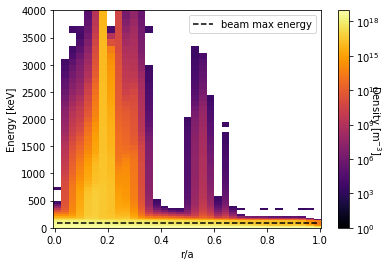

In [19]:
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('axes', titlesize = 10)
plt.rc('figure', titlesize = 10)
plt.rc('legend', fontsize = 10)
#"""
fig, ax = plt.subplots()
# pcm = ax.pcolormesh(energyCenters, rya, energeticDensity, 
#                 norm=colors.LogNorm(vmin=1, vmax=np.max(energeticDensity)),
#                 shading = 'nearest')
# print('---')
# print(rya.shape)
pcm = ax.pcolormesh(rya.T, energyCenters.T, energeticDensity.T, 
                norm=colors.LogNorm(vmin=1, vmax=np.max(energeticDensity.T)),
                shading = 'nearest', cmap='inferno')

cbar = fig.colorbar(pcm, ax=ax)#, extend='max')
cbar.set_label(r'Density [m$^{-3}$]', rotation=270)
ax.set_ylim([0,4000])
plt.savefig('heatmap.png')
plt.plot(rya, (rya/rya)*ebkev, 'k--', label='beam max energy')
plt.xlabel('r/a')
plt.ylabel('Energy [keV]')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Ion Density vs. Energy at r/a = 0.24059')

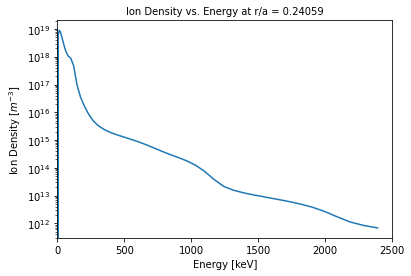

In [20]:
# Ion Density versus Energy at r/a = rya[i_rho]
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('axes', titlesize = 10)
plt.rc('figure', titlesize = 10)
plt.rc('legend', fontsize = 10)


max_energy_to_plot = 2500 # [keV]
i_max_E = np.argmin(np.abs(energyCenters - max_energy_to_plot))
energetic_particles_at_rho = energeticDensity[i_rho, :]
plt.yscale("log")
plt.plot(energyCenters[:i_max_E], energetic_particles_at_rho[:i_max_E])
plt.xlim([0, max_energy_to_plot])
plt.xlabel('Energy [keV]')
plt.ylabel(r'Ion Density [$m^{-3}$]')
plt.title(f'Ion Density vs. Energy at r/a = {rya[i_rho]}')


Text(0, 0.5, 'Ion Density for E_ion > 200 keV [$m^{-3}$]')

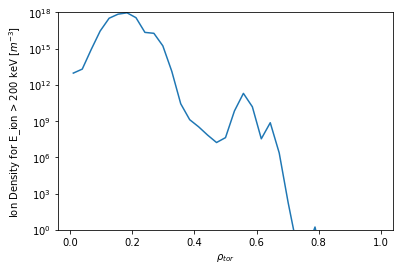

In [21]:
# Ion density versus r/a. Integrated over all energies. 

energeticDensity_1D = np.zeros(len(rya))
min_E = 200 # [keV] TODO: for now this must be larger than 2 KeV
E_idx = np.argmin(np.abs(min_E - enerkev))

#this is the radial part of the spherical jacobian
energeticDensity_1D = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,E_idx:]*relevantVels[E_idx:]**2,
    relevantVels[E_idx:]))

energeticDensity_1D = energeticDensity_1D*1e6 # convert to m^-3
plt.yscale('log')
plt.ylim([1e0, 1e18])
plt.plot(rya, energeticDensity_1D)
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(f'Ion Density for E_ion > {min_E} keV' + r' [$m^{-3}$]')


dict_keys(['version', 'mnemonic', 'ampfmod', 'urfmod', 'rdcmod', 'frmod', 'beamplse', 'transp', 'tavg', 'f4d_out', 'netcdfshort', 'eqdskin', 'ngen', 'ntotal', 'kspeci', 'bnumb', 'fmass', 'lrzmax', 'radcoord', 'rya', 'Rp', 'Rm', 'rhomax', 'radmaj', 'rpmconz', 'btor', 'toteqd', 'rgeomp', 'r0geomp', 'rmag', 'zmag', 'eqsym', 'zshift', 'eps0', 'elong', 'zgeomp', 'rgeom1', 'rgeom2', 'area', 'darea', 'vol', 'dvol', 'equilpsi', 'psivalm', 'dpsi', 'psimag', 'psilim', 'h_r', 'qsafety', 'curreq', 'lrz', 'lrindx', 'jx', 'x', 'enerkev', 'uoc', 'dx', 'cint2', 'vnorm', 'enorm', 'iy', 'y', 'dy', 'cynt2', 'iy_', 'itl', 'itu', 'lz', 'z', 'dz', 'solrz', 'solzz', 'pol', 'bbpsi', 'imax', 'lmax', 'zboun', 'zmaxpsi', 'tau', 'dtau', 'beampon', 'beampoff', 'tavg1', 'tavg2', 'ndeltarho', 'bthr', 'btoru', 'btor0', 'bmidplne', 'efflag', 'softxry', 'ipronn', 'gamafac', 'pellet', 'imp_type', 'nstates', 'fmass_imp', 'pellet_M0', 'pellet_Cablation', 'npa_diag', 'sigmamod', 'time', 'bctshift', 'bctimescal', 'nsave', '

Text(0.5, 1.0, 'Total Absorbed RF power: 0.9614 MW')

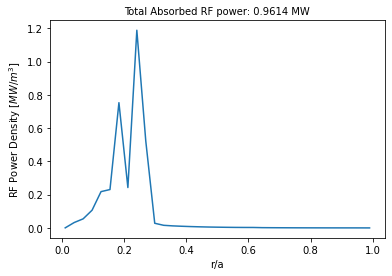

In [22]:
# Now want to do absorbed power partition 

print(cql_nc.variables.keys())
print(cqlrf_nc.variables.keys())

rf_power_density = cql_nc.variables["powrft"][-1]#convert to W/m^3
print(rf_power_density.shape)
plt.plot(rya, rf_power_density)
plt.xlabel('r/a')
plt.ylabel(r'RF Power Density [$MW/m^3$]')

dvol = cql_nc.variables['dvol'][:]

total_RF_power = np.trapz(rf_power_density*dvol)
#print(f'test: {sum(rf_power_density*dvol/1e6)}')
print(f'Total RF power: {round(total_RF_power)/1e6} MW')
plt.title(f'Total Absorbed RF power: {round(total_RF_power/1e6, 4)} MW')


4.5977096802915884e-20
(155, 35)


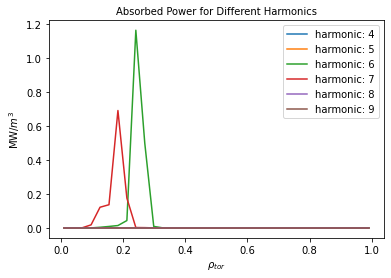

In [38]:
# RF power to mode l for species 0 (ions)
powrf = cql_nc.variables['powrf'][:]
final_powrf = np.ma.getdata(powrf[-1, :, :])
final_powrf = final_powrf  # convert to MW 
print(max(final_powrf[5,:]))
print(final_powrf.shape)
num_harmonics_to_plot = 6 # nharms, the number of harmonics to plot for genral species 0
harm0 = 4 # the first harmonic: should be nharm1 for gen species 0. index 0 in num_harmonics is 4
for i in range(num_harmonics_to_plot):
    plt.plot(rya, final_powrf[i,:], label=f'harmonic: {i+harm0}')

plt.legend()
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'MW/$m^3$')
plt.title('Absorbed Power for Different Harmonics')

final_powrfe = final_powrf[num_harmonics_to_plot:, :]

(0.0, 0.2)

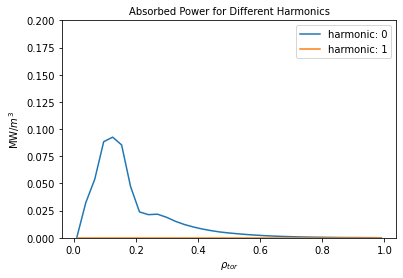

In [47]:
# RF power to mode l for species 1 (electrons)
num_harmonics_to_plot = 2 # nharms, the number of harmonics to plot for genral species 0
harm0 = 0 # the first harmonic: should be nharm1 for gen species 0. index 0 in num_harmonics is 4
for i in range(num_harmonics_to_plot):
    plt.plot(rya, final_powrfe[i,:], label=f'harmonic: {i+harm0}')

plt.legend()
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'MW/$m^3$')
plt.title('Absorbed Power for Different Harmonics')
plt.ylim([0, 0.2])

In [48]:
# fusion power plotting area 
fusion_power = cql_nc.variables['fuspwrv']
fusion_power = fusion_power[:, :]*1e6 #W/m^3
labels = ['N/A', 'N/A', 'd+d -> T + p', 'd+d -> he3 + n']
for i in range(fusion_power.shape[0]):
    plt.plot(rya, fusion_power[i, :], label=labels[i])

plt.ylabel(r'Fusion Power W/$m^3$')
plt.xlabel(r'$\rho_{tor}$')

fusion_power_rho_t = np.zeros_like(rya)
for i in range(fusion_power.shape[0]):
    fusion_power_rho_t = fusion_power_rho_t + fusion_power[i, :]
plt.plot(rya, fusion_power_rho_t, label='Total')
plt.legend()

sumed_fusion_power = np.trapz(fusion_power_rho_t*dvol) * (1/100)**3
print(f'Total Fusion Power: {sumed_fusion_power}')

total_fusion_power_from_file = sum(cql_nc.variables['fuspwrvt'][:])
print(f'Total Fusion Power from File: {total_fusion_power_from_file}')

KeyError: 'fuspwrv'

The shape of powers is: (2, 13, 35)
[3.45950851e-04 2.97000109e-02 4.92839081e-02 8.04686922e-02
 8.38377635e-02 7.71092097e-02 4.26153507e-02 2.15247097e-02
 1.93155121e-02 1.97466547e-02 1.72278504e-02 1.38394152e-02
 1.11516863e-02 9.09780629e-03 7.39167603e-03 6.01760382e-03
 4.88345296e-03 3.98546178e-03 3.23634861e-03 2.62209581e-03
 2.12186154e-03 1.70626171e-03 1.39096782e-03 1.12425393e-03
 9.08787121e-04 7.34379416e-04 5.89447457e-04 4.83859913e-04
 3.93023840e-04 3.02607941e-04 2.41580347e-04 2.01457523e-04
 1.69762285e-04 1.25181173e-04 5.55218475e-07]
The total RF power to the general species is 0.12090873749522126 MW
The total power to the maxw ion is 0.5449147259014034 MW
The total power to the maxw e is -8.52266122181578 MW
The total ion particle src power to gen is 0.0 MW


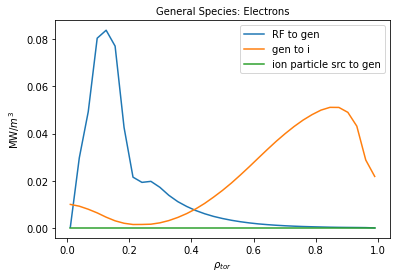

In [50]:
# Make plots of the way energy is partitioned to the main species.. seems sketchy 
gen_species_num = 1
plot_self_coll = 'False'
if gen_species_num == 0:
    spec = 'General Species: Ions'
else:
    spec = 'General Species: Electrons'

powers = cql_nc.variables['powers'][-1, :, :, :]
print(f'The shape of powers is: {powers.shape}')
print(powers[1, 4, :])
powers = powers[gen_species_num, :, :]  # get the only general species
powers_RF_to_gen = powers[4, :]
powers_collisions_with_electrons = powers[0, :]
powers_collisions_with_ions = powers[1, :]
powers_ion_particle_source = powers[5, :]

plt.plot(rya, powers_RF_to_gen, label='RF to gen')

if plot_self_coll == 'True':
    plt.plot(rya, powers_collisions_with_ions, label='gen to i')
    plt.plot(rya, powers_collisions_with_electrons, label='gen to e')

elif plot_self_coll != 'True' and gen_species_num ==0:
    plt.plot(rya, powers_collisions_with_electrons, label='gen to e')

elif plot_self_coll != 'True' and gen_species_num == 1:
    plt.plot(rya, powers_collisions_with_ions, label='gen to i')
    


#plt.plot(rya, powers_collisions_with_electrons, label='gen to e')
#plt.plot(rya, powers_collisions_with_ions, label='gen to i')
plt.plot(rya, powers_ion_particle_source, label='ion particle src to gen')
plt.title(spec)
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'MW/$m^3$')
plt.legend()
total_power_to_general = np.trapz((powers_RF_to_gen)*dvol*(1/100)**3)
total_power_to_max_ion = np.trapz((powers_collisions_with_ions)*dvol*(1/100)**3)
total_power_to_max_e = np.trapz((powers_collisions_with_electrons)*dvol*(1/100)**3)
total_power_ion_src = np.trapz((powers_ion_particle_source)*dvol*(1/100)**3)
print(f'The total RF power to the general species is {total_power_to_general} MW')
print(f'The total power to the maxw ion is {total_power_to_max_ion} MW')
print(f'The total power to the maxw e is {total_power_to_max_e} MW')
print(f'The total ion particle src power to gen is {total_power_ion_src} MW')

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from matplotlib.collections import LineCollection

# plt.rc('xtick', labelsize = 14)
# plt.rc('ytick', labelsize = 14)
# plt.rc('axes', labelsize = 16)
# plt.rc('axes', titlesize = 16)
# plt.rc('figure', titlesize = 18)
# plt.rc('legend', fontsize = 14)

# import os,sys
# currentdir = os.path.dirname(os.path.realpath(__file__))
# parentdir = os.path.dirname(currentdir)
# sys.path.append(parentdir)
# import getGfileDict
# gfileDict = getGfileDict.getGfileDict(pathprefix=f'{parentdir}/')

from scipy.signal import find_peaks

# import netCDF4
# cqlrf_nc = netCDF4.Dataset(f'{parentdir}/cql3d_krf001.nc','r')
# cql_nc = netCDF4.Dataset(f'{parentdir}/cql3d.nc','r')

def getSPA():
    """
    Finds single pass absorbtion using 
    1) energy at reflection point if ray is reflected
    2) assume all ray energy deposited if not reflected 
    Jacob fixed bug ignoring rays that did not reflect in SPA calculation 
    """
    radialVariable = (np.copy(cqlrf_nc.variables["spsi"]))
    delpwr= np.copy(cqlrf_nc.variables["delpwr"])


    #initialize SPA to zero. 
    averageSPA = 0
    bounceRho = .96  # if the ray turns after rho = 0.96, consider it reflected
   
    #fig,ax = plt.subplots()
    offset = 1500     # reject turning points at eary times 
    ticker = 0
    for i in range(len(delpwr)):  # loop through the rays
        peakIndices, _ = find_peaks(radialVariable[i], height = bounceRho)
        relevantIndices = peakIndices[peakIndices > offset]
        
        #print(len(relevantIndices))
        if len(relevantIndices) > 0:
            bounceIndex = relevantIndices[0]
            SPA = 1-delpwr[i][bounceIndex]/delpwr[i][0]
            averageSPA += SPA
            ticker = ticker + 1 
        elif len(relevantIndices) == 0:
            SPA = 1
            averageSPA += SPA

    #print(f'ticker: {ticker}')  
    averageSPA /= len(delpwr)
    print(f"average SPA: {averageSPA}")
    return averageSPA
       
getSPA()

average SPA: 0.9863105582160347


0.9863105582160347

In [52]:
print(cql_nc.variables.keys())
delpwr = cqlrf_nc.variables['delpwr']
print(delpwr.shape)
print(len(delpwr))

dict_keys(['version', 'mnemonic', 'ampfmod', 'urfmod', 'rdcmod', 'frmod', 'beamplse', 'transp', 'tavg', 'f4d_out', 'netcdfshort', 'eqdskin', 'ngen', 'ntotal', 'kspeci', 'bnumb', 'fmass', 'lrzmax', 'radcoord', 'rya', 'Rp', 'Rm', 'rhomax', 'radmaj', 'rpmconz', 'btor', 'toteqd', 'rgeomp', 'r0geomp', 'rmag', 'zmag', 'eqsym', 'zshift', 'eps0', 'elong', 'zgeomp', 'rgeom1', 'rgeom2', 'area', 'darea', 'vol', 'dvol', 'equilpsi', 'psivalm', 'dpsi', 'psimag', 'psilim', 'h_r', 'qsafety', 'curreq', 'lrz', 'lrindx', 'jx', 'x', 'enerkev', 'uoc', 'dx', 'cint2', 'vnorm', 'enorm', 'iy', 'y', 'dy', 'cynt2', 'iy_', 'itl', 'itu', 'lz', 'z', 'dz', 'solrz', 'solzz', 'pol', 'bbpsi', 'imax', 'lmax', 'zboun', 'zmaxpsi', 'tau', 'dtau', 'beampon', 'beampoff', 'tavg1', 'tavg2', 'ndeltarho', 'bthr', 'btoru', 'btor0', 'bmidplne', 'efflag', 'softxry', 'ipronn', 'gamafac', 'pellet', 'imp_type', 'nstates', 'fmass_imp', 'pellet_M0', 'pellet_Cablation', 'npa_diag', 'sigmamod', 'time', 'bctshift', 'bctimescal', 'nsave', '

48


(105.44260634132884, 231.6407386286921, -19.01609764915225, 27.306145564917337)

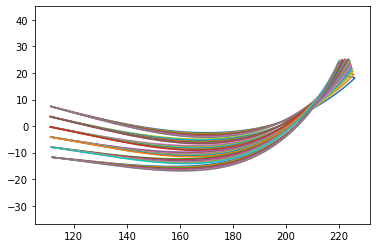

In [53]:
# Ray traces 

wr  = cqlrf_nc.variables["wr"][:] #major radius of the ray at each point along the trace
wz  = cqlrf_nc.variables["wz"][:]

print(len(wr))
for i_ray in range(len(wr)):
    plt.plot(wr[i_ray, :], wz[i_ray, :])

plt.axis('equal')

(48, 10000)
(48, 10000)


Text(0, 0.5, '$N_{||}$')

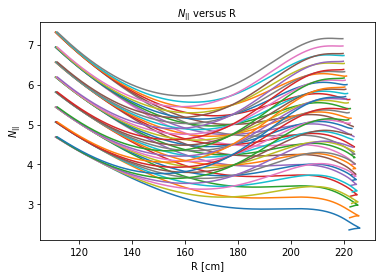

In [54]:
# calculate the parallel velocity versus rho from the refractive index 
wnpar = cqlrf_nc.variables['wnpar'][:]
print(wnpar.shape)
print(wr.shape)

spsi_rays = cqlrf_nc.variables["spsi"]
num_rays = wr.shape[0]

for i in range(num_rays):
    # plt.plot(spsi_rays[i, :], wnpar[i, :])
    plt.plot(wr[i, :], wnpar[i, :])

plt.title(r'$N_{||}$ versus R')
plt.xlabel('R [cm]')
plt.ylabel(r'$N_{||}$')


vnorm = 3219264936.416373
vnorm/c = 10.73088312138791
29434443.55179567
108022240921.87401


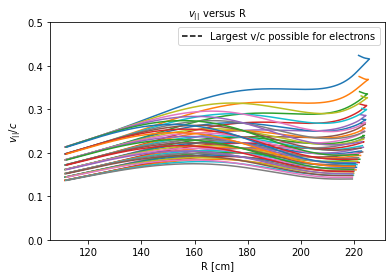

In [55]:
# calculate v_|| versus R 
c = 3e8
v_para = c / wnpar

for i in range(num_rays):
    # plt.plot(spsi_rays[i, :], wnpar[i, :])
    plt.plot(wr[i, :], v_para[i, :]/c)

plt.title(r'$v_{||}$ versus R')
plt.xlabel('R [cm]')
plt.ylabel(r'$v_{||}/c$')

# Now, calculate the v_para from the electrons and see if the particles are fast enough. 
vnorm = cql_nc.variables["vnorm"][:] * (1/100)
print(f'vnorm = {vnorm}') 
print(f'vnorm/c = {vnorm/c}')
m_e = 9.101e-31
m_D = 3.34e-27
e_elec = 0.5*m_e*vnorm**2 / 1.6022e-19
e_ion = 0.5*m_D*vnorm**2 / 1.6022e-19
print(e_elec)
print(e_ion)
plt.plot(wr[1, :], vnorm*wr[1, :]/(c*wr[1, :]), 'k--', label='Largest v/c possible for electrons')
plt.ylim(0, 0.5)
plt.legend()


In [56]:
genray_inputFileDict = getInputFileDictionary.getInputFileDictionary('genray',pathprefix=path)
print(genray_inputFileDict['grill'].keys())
print(genray_inputFileDict['grill']['anmin(1)'])
print(genray_inputFileDict['grill']['anmax(1)'])
n_par_min = genray_inputFileDict['grill']['anmin(1)']
n_par_max = genray_inputFileDict['grill']['anmax(1)']
n_par = (n_par_min + n_par_max) / 2
frqcy = genray_inputFileDict['wave']['frqncy']
omega = 2*np.pi*frqcy
print(frqcy)
print(omega)
k_par = n_par*omega / c

dict_keys(['i_n_poloidal', 'i_rho_cutoff', 'ngrill', 'igrillpw', 'igrilltw', 'rhopsi0(1)', 'thgrill(1)', 'phigrill(1)', 'height(1)', 'nthin(1)', 'anmax(1)', 'anmin(1)', 'nnkpar(1)', 'powers(1)'])
4.5
7.5
96000000.0
603185789.4892403


In [57]:
# get the background B field to get the cyclotron resonances
import getGfileDict
from scipy.interpolate import interp2d
parentdir = '../../GENRAY_CQL_Scripts/'
gfileDict = getGfileDict.getGfileDict(pathprefix=f'{parentdir}')

#below are the variables required to work with the magnetic field
rgrid = gfileDict["rgrid"]
print(rgrid.shape)
zgrid = gfileDict["zgrid"]
magAxisR = gfileDict['rmaxis'] 
magAxisZ = gfileDict['zmaxis'] 
B_zGrid = gfileDict["bzrz"]
B_TGrid = gfileDict["btrz"]
B_rGrid = gfileDict["brrz"]

# get the total feild strength 
Bstrength = np.sqrt(np.square(B_zGrid) + np.square(B_TGrid) + np.square(B_rGrid))
getBStrength = interp2d(rgrid,zgrid,Bstrength, kind = 'cubic')

def Omega_D(R, Z):
    q = 1.6022e-19
    return q*getBStrength(R, Z) / m_D

shotNum: 174658
(65,)


In [58]:
# for a representitive ray, calc the condition v_par_i + l*Omega_c(R) / k_par and see if the condition is satisfied for l = 4, 5, 6, 7, 8 over the radius 

# first, lets get a sense for how far a beam ion is from the resonance condition:
E_D =  ebkev*1.6022e-19*(1000 / 1)
vb_D = np.sqrt(2*E_D / m_D)
print(vb_D)

print(vb_D * k_par)
print(omega)
print(r'The resonance condition omega = v_par*k_par is not satisfied for beam ions: they are too slow.')


2770416.8604811663
33421521.624072697
603185789.4892403
The resonance condition omega = v_par*k_par is not satisfied for beam ions: they are too slow.


vnorm = 3219264936.416373
vnorm/c = 10.73088312138791
29461610.821967635
108022240921.87401


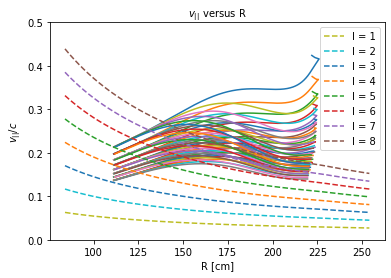

In [59]:
# Assume v_beam is parallel to the wave. what harmonics bring the system into resonance? 

# get frequencies along the midplane 
Omega_D_array = Omega_D(rgrid, 0)

l_array = [1, 2, 3, 4, 5, 6, 7, 8] # mode number

# calculate v_|| versus R 
c = 3e8
v_para = c / wnpar

for i in range(num_rays):
    # plt.plot(spsi_rays[i, :], wnpar[i, :])
    plt.plot(wr[i, :], v_para[i, :]/c)

plt.title(r'$v_{||}$ versus R')
plt.xlabel('R [cm]')
plt.ylabel(r'$v_{||}/c$')

# Now, calculate the v_para from the electrons and see if the particles are fast enough. 
vnorm = cql_nc.variables["vnorm"][:] * (1/100)
print(f'vnorm = {vnorm}') 
print(f'vnorm/c = {vnorm/c}')
m_e = 9.1094e-31
m_D = 3.34e-27
e_elec = 0.5*m_e*vnorm**2 / 1.6022e-19
e_ion = 0.5*m_D*vnorm**2 / 1.6022e-19
print(e_elec)
print(e_ion)

for l in l_array:
    plt.plot(rgrid*100, vb_D/c + l*Omega_D_array/(c*k_par), '--', label=f'l = {l}')
plt.ylim(0, 0.5)
plt.legend()



In [10]:
# get the required enorme for electrons. 
import numpy as np
c = 3e8
m_e = 9.101e-31
m_D = 3.34e-27
Te = 1000 # KeV
E_th_e = 1.6022e-19 * Te * 1000 # convert KeV to J
E_D_kev = 12500
E_D =  E_D_kev*1.6022e-19*(1000 / 1)
vb_D = np.sqrt(2*E_D / m_D)
vth_e = np.sqrt(2*E_th_e / m_e)
print(f'The thermal electron velocity is {vth_e}')
print(f'The ion velocity for {E_D_kev} is {vb_D}')
print(vth_e/c)
print(vnorm/c)
target_enorme = 0.5*m_e*(10*vth_e)**2
print(f'Target enorme: {target_enorme/(1e6 * 1.6022e-19)} MeV')

The thermal electron velocity is 593374398.3135799
The ion velocity for 12500 is 34630210.75601458
1.9779146610452665


NameError: name 'vnorm' is not defined

In [2]:
# raynum = delpwr[1, :]
# plt.plot(raynum*1e-7/1e6)
# sum1 = 0
# for i in range(len(delpwr)):
#     pwr = delpwr[i, 0]
#     sum1 = sum1 + pwr

# sum1 = sum1*1e-7/1e6
# print(sum1)


NameError: name 'np' is not defined

In [196]:
# # grab the power to the ion 
# sdpwr = cqlrf_nc.variables['sdpwr']
# power_to_ions = 0
# for i in range(len(sdpwr)):
#     ray_i_power = sum(sdpwr[i, :])
#     power_to_ions += ray_i_power

# power_to_ions = power_to_ions * 1e-7 # convert to jouls
# print(f'The total power to the ions is {power_to_ions} W')
# plt.plot(sdpwr[0, :])